# (0) Introduction
<br/>

### Links and notes useful during the workshop

1. Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
2. Data description: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/download/data_description.txt
3. Bias-variance tradeoff: http://scott.fortmann-roe.com/docs/BiasVariance.html

## (1) Init & Setup

In [1]:
import pandas as pd, io, pandas_profiling as pdp, warnings, seaborn as sns, numpy as np,  xgboost as xgb, matplotlib, workshop_utils
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from xgboost import plot_tree

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### (2) Load data from Google Cloud Storage
* DataLab magic commands: http://googledatalab.github.io/pydatalab/datalab.magics.html
* pandas.read_csv: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [2]:
%%gcs read --object gs://test-always-free.appspot.com/kaggle-house-prices/train.csv --variable train

In [3]:
%%gcs read --object gs://test-always-free.appspot.com/kaggle-house-prices/test.csv --variable test

In [4]:
train = pd.read_csv(io.BytesIO(train))
test = pd.read_csv(io.BytesIO(test))

### (3) How does the data look like? <span style="color:green">*Experiment*</span>
* <span style="color:green">Play around with different functions</span><br /><br />
* pandas.DataFrame.head: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html
* pandas.DataFrame.shape: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html
* pandas.DataFrame.columns: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.columns.html
* pands.DataFrame.info: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html
* pandas.DataFrame.describe: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html
* pandas.Series.value_counts: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html

In [8]:
train.head(5)
train.describe()

train.shape

(1460, 81)

# (4) Outliers <span style="color:green">*Experiment*</span>

* <span style="color:green">Change x. Examples: OverallQual, GrLivArea, YearBuilt, LotFrontage</span>

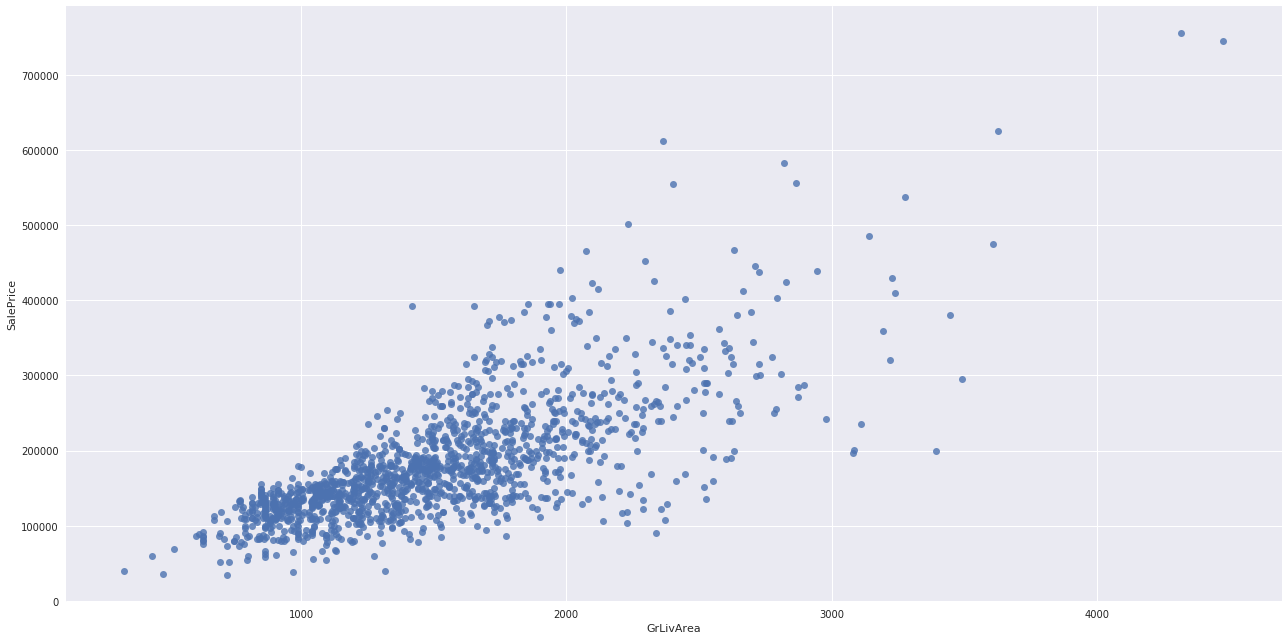

In [12]:
sns.lmplot(x='GrLivArea', y='SalePrice', data=train, fit_reg=False, size=9, aspect=2)

### (5) Remove suspiciously cheap big houses
* pandas.DataFrame.drop: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
* pandas.DataFrame.index: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.index.html

In [14]:
 train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index)
sns.lmplot(x='GrLivArea', y='SalePrice', data=train, fit_reg=False, size=9, aspect=2)

KeyError: "['SalePrice'] not in index"

### (6) Extract SalePrice to a separate variable, merge train and test sets, log SalePrice, create temporary one-hot-encoding
* Pandas vs NumPy: https://stackoverflow.com/questions/11077023/what-are-the-differences-between-pandas-and-numpyscipy-in-python
* pandas.concat: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html
* pandas.DataFrame.pop: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pop.html
* One-hot-encoding
  * pandas.get_dummies: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
* Logarithm of prices
  * numpy.log: https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html

In [13]:
train_prices = train.pop('SalePrice')
train_prices_log = np.log(train_prices)
features = pd.concat([train, test], keys=['train', 'test'])
features_dummy_tmp = pd.get_dummies(features)

In [18]:
len(list(features_dummy_tmp.columns))

288

### (6.1) Correlations

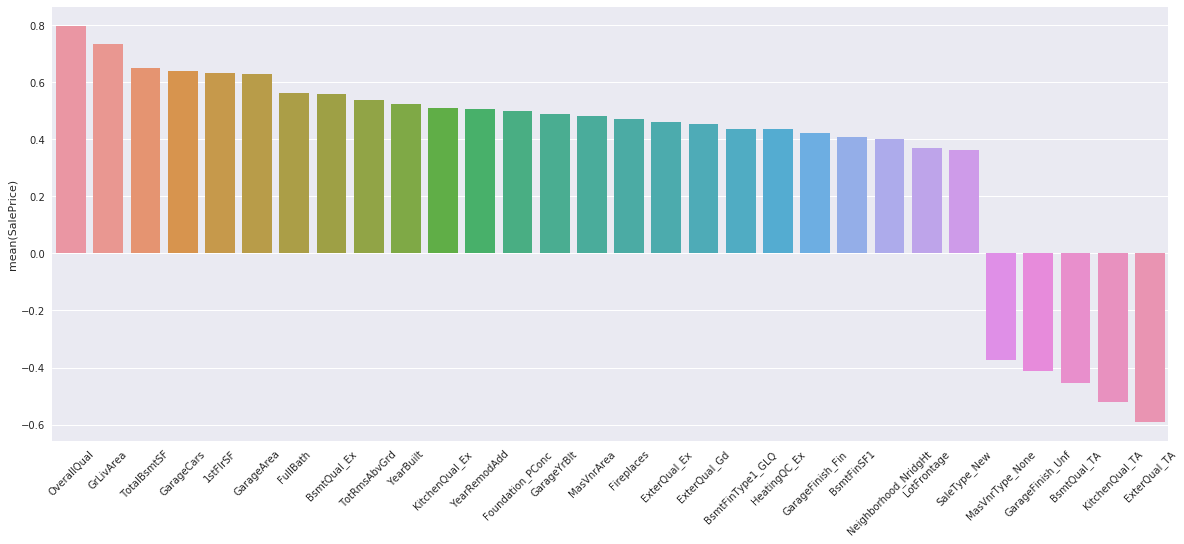

In [15]:
workshop_utils.correlation_barplot(features_dummy_tmp.loc['train'], train_prices, 30)

### (7) Let's see if we can predict price using a "blind" XGBoost model without doing any data engineering
* Supervised learning
  * Scikit-learn: http://scikit-learn.org/stable/tutorial/basic/tutorial.html#learning-and-predicting
* Cross validation
  * sklearn.model_selection.train_test_split: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
* XGBoost
  * Decision trees
* numpy.exp: https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html

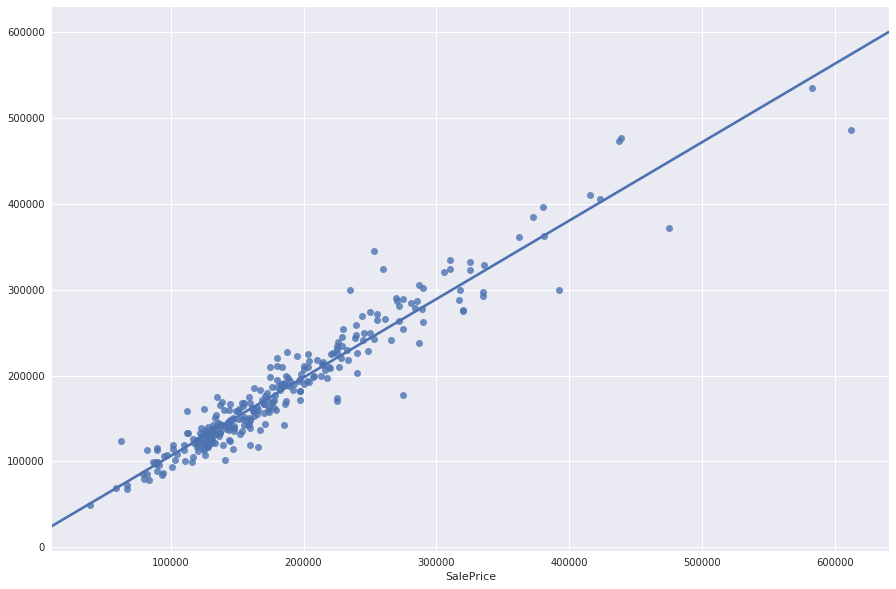

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features_dummy_tmp.loc['train'], train_prices_log, test_size=0.2, random_state = 2)

xgb_model = workshop_utils.xgbRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
plt.figure(figsize=(15,10))
plot = sns.regplot(np.exp(y_test), np.exp(y_pred), ci=None)

### (8) Mean squared error
* sklearn.metrics.mean_squared_error: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
* Why are we using MSE vs MAE?

In [20]:
mean_squared_error(y_test, y_pred)

0.013141822793872777

### (9) What are the cases over 10% off?  <span style="color:green">*Experiment*</span>
* <span style="color:green">Change cutoff (last) function parameter</span><br /><br />
* pandas.DataFrame.join: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html
* pandas.DataFrame.set_index: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.set_index.html
* pandas.DataFrame.rename: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html
* pandas.DataFrame.abs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.abs.html
* pandas.DataFrame.sort_values: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html

In [21]:
off_1 = workshop_utils.price_diff_over(features.loc['train'], y_test, y_pred, 0).describe()
off_1

,DiffRatio
count,292.000000
mean,8.242992
std,9.044928
min,0.054369
25%,2.969524
50%,5.787837
75%,9.971417
max,98.916985


### Would give 0.13336 on Kaggle

### (10) Data profile
* Median. 2nd quartile, 5th decile, and 50th percentile
* Variance and standard deviation
* Skewness

In [ ]:
pdp.ProfileReport(features)

# Handling missing data

### (11) Categorical features with missing values (does not include zeros)
* pandas.DataFrame.isnull: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isnull.html
* pandas.DataFrame.sum: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sum.html
* pandas.Series.to_frame: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.to_frame.html

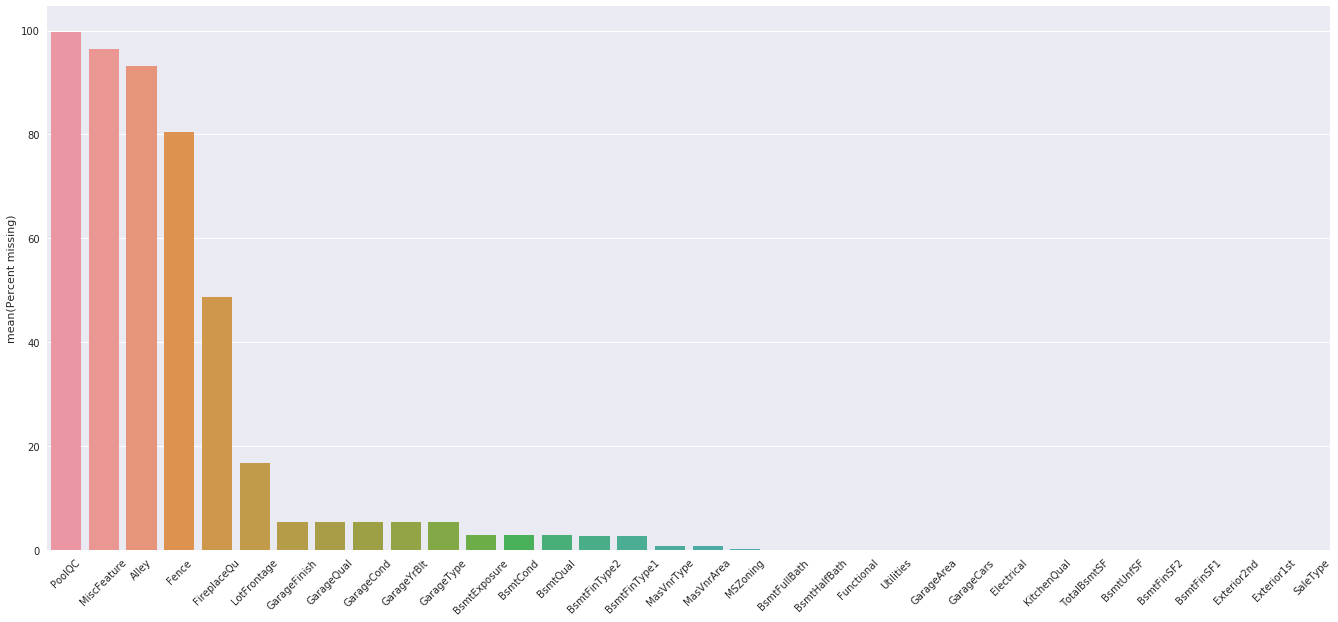

In [22]:
nulls_count = features.isnull().sum().to_frame()
nulls_count['Percent missing'] = (nulls_count[0] / features.shape[0]) * 100
nulls_count = nulls_count[nulls_count[0] > 0].sort_values(by=0, ascending=False)

plt.figure(figsize=(23,10))
workshop_utils.missing_barplot(nulls_count)

### (12) Drop columns with majority of missing data

* Id is an identifier of a row. We do not want it to be a 'feature'
* PoolQC (pool quality) goes with PoolArea (size of pool)
* MiscFeature (viariety of features, like) goes with MiscVal (value of miscellaneous feature)
* Utilities (Electricity, Gas, Water, Septic Tank) - Virtually everything is AllPub

**MiscFeature: Miscellaneous feature not covered in other categories**
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA      None
       
**Utilities: Type of utilities available**
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO       Electricity only

In [23]:
features = features.drop(['Id', 'PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal', 'Utilities'], axis=1)

### (13) Categorical features: Converting `null` to a proper category
* Alley is 93.22% is missing, but it means "No access"
* Fence is 80.44% missing, but it means "No access"
* FireplaceQU has 48.65% missing values, but the meaning of missing is "no fireplace"
<hr>
* pandas.DataFrame.fillna: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html

In [24]:
features['Alley'] = features['Alley'].fillna('None')
features['Fence'] = features['Fence'].fillna('None')
features['FireplaceQu'] = features['FireplaceQu'].fillna('None')

### (14) Categorical features: Filling missing data with mode
* pandas.DataFrame.mode: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mode.html

In [25]:
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

features['Functional'] = features['Functional'].fillna('Typ')

### (15) Numerical features: Filling missing data with mean <span style="color:green">*Experiment*</span>
* <span style="color:green">Pick one option</span><br/><br/>
* LotFrontage has 17.7% empty values
<hr>
* pandas.DataFrame.mean: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mean.html
* pandas.DataFrame.median:https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.median.html
* pandas.DataFrame.groupby: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
* pandas.DataFrame.transform: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.transform.html

In [26]:
# features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())
features['LotFrontage'] = features.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### (16) Garage attributes are null only when there is no garage
* pandas.Series.notnull: https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.notnull.html

In [ ]:
features[features['GarageYrBlt'].isnull()   & features['GarageQual'].notnull()].shape[0] + \
features[features['GarageArea'].isnull()    & features['GarageQual'].notnull()].shape[0] + \
features[features['GarageCars'].isnull()    & features['GarageQual'].notnull()].shape[0] + \
features[features['GarageType'].isnull()    & features['GarageQual'].notnull()].shape[0] + \
features[features['GarageFinish'].isnull()  & features['GarageQual'].notnull()].shape[0] + \
features[features['GarageCond'].isnull()    & features['GarageQual'].notnull()].shape[0]

### (17) Make it all zeros for numerical and 'None' for categorical variables

In [ ]:
for f in ['GarageYrBlt', 'GarageArea', 'GarageCars']: features[f] = features[f].fillna(0)
for f in ['GarageType', 'GarageFinish', 'GarageCond', 'GarageQual']: features[f] = features[f].fillna('None')

### (18) For `basement`, there are just few discrepancies

In [ ]:
features[features['BsmtCond'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['BsmtExposure'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['BsmtFinType1'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['BsmtFinType2'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['BsmtFinSF1'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['BsmtFinSF2'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['BsmtUnfSF'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['TotalBsmtSF'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['BsmtFullBath'].isnull() & features['BsmtQual'].notnull()].shape[0] + \
features[features['BsmtHalfBath'].isnull() & features['BsmtQual'].notnull()].shape[0]

### (19) Just 7 discrepancies. Let's ignore it for the sake of simplicity. All are categorical.

In [ ]:
for f in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']: features[f] = features[f].fillna(0)
for f in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']: features[f] = features[f].fillna('None')

### (20) Masonry Veneer

In [ ]:
features[features['MasVnrArea'].isnull() & features['MasVnrType'].notnull()].shape[0]

### (21) There is just one that has area but no type

In [ ]:
features['MasVnrArea'] = features['MasVnrArea'].fillna(0)
features['MasVnrType'] = features['MasVnrType'].fillna('None')

# Handling invalid data types

### (22) MSSubClass should be categorical
* pandas.Series.astype: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.astype.html

In [ ]:
features['MSSubClass'] = features['MSSubClass'].astype(str)

### (23) Dates should be categorical <span style="color:green">*Experiment*</span>

* <span style="color:green">Should year of sale be categorical?</span><br /><br />

* YrSold has just 5 distinct values
* MoSold is a classic categorical candidate

In [ ]:
#features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

### (24) CentralAir is just two values (Y/N). Make it 0/1
* pandas.series.replace: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.replace.html

In [ ]:
features['CentralAir'] = features['CentralAir'].replace({"Y": 1, "N": 0})

### (25) Should all categorical variables be categorical? <span style="color:green">*Experiment*</span>
* <span style="color:green">Change x to other *Qual features, i.e: BsmtQual, BsmtCond, ExterCond</span>
<br /><br />
ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
       
<hr>

* pandas.DataFrame.assign: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.assign.html
		

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x='ExterQual', y='SalePrice', data=features.loc['train'].assign(SalePrice=train_prices_log))

### (26) Convert quality related categorical variables to numbers
* pandas.Series.map: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html

In [ ]:
for f in ['KitchenQual', 'BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond', 'GarageCond', 'GarageQual', 'FireplaceQu', 'HeatingQC']:
    features[f] = features[f].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0})
for f in ['BsmtExposure']:
    features[f] = features[f].map({'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4})

### (27) How does the bar plot look like after the features are mapped? <span style="color:green">*Experiment*</span>

In [ ]:
# <...>

### (27.1) How does the data look right now? <span style="color:green">*Experiment*</span>

In [ ]:
# <...>

# (28) Feature engineering <span style="color:green">*Experiment*</span>

* <span style="color:green">Should Exterion1st and Exterior2nd be merged?</span>
<br /><br />

* pandas.Series.str: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.html

In [ ]:
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features['Cond_Combined'] = features['Condition1'].str.cat(features['Condition2'].astype(str), sep="_")
features['Exterior_Combined'] = features['Exterior1st'].str.cat(features['Exterior2nd'].astype(str), sep="_")

### (29) Drop excessive features <span style="color:green">*Experiment*</span>

* <span style="color:green">Have you merged Exterior1st and Exterior2nd?</span>

In [ ]:
features = features.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd'], axis=1)

### (30) One-hot-encoding
* Why do we need to re-encode?

In [ ]:
features_dummy = pd.get_dummies(features)

### (31) How do correlations look like after feature-engineering?

In [ ]:
workshop_utils.correlation_barplot(features_dummy.loc['train'], train_prices, 30)

### (32) Final look at the data report <span style="color:green">*Experiment*</span>

* <span style="color:green">See the data before one-hot-encoding, too</span>

In [ ]:
# <...>

# Normalization

### (33) Distribution of prices

In [ ]:
plt.figure(figsize=(20,8))
sns.distplot(train_prices)

### (34) Log distribution of prices <span style="color:green">*Experiment*</span>

In [ ]:
# <...>

## (35) Linear regression approach
How the linear regression model performs with single-step cross valuidation? This is the least squares method.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_dummy.loc['train'], train_prices_log, test_size=0.2, random_state = 2)
model = linear_model.LinearRegression(copy_X = True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(20,8))
sns.regplot(np.exp(y_test), np.exp(y_pred), ci=None)

### (35.1) How do coefficients look like?

In [ ]:
pd.DataFrame(model.coef_).set_index(pd.Index(list(X_train))).sort_values(by=0)

### (36) Linear regression: What is the mean squared error?

In [ ]:
mean_squared_error(y_test, y_pred)

### (37) What are the cases over 10% off?

In [ ]:
off_2 = workshop_utils.price_diff_over(features_dummy.loc['train'], y_test, y_pred, 0).describe()
off_2

### (38) How does this compare to the previous (raw) result with XGBoost? <span style="color:green">*Experiment*</span>
* Hint: lsuffix, rsuffix may be needed

In [ ]:
# <...>

### (39) Linear regression: Cross-validation with 5 iterations <span style="color:green">*Experiment*</span>
* <span style="color:green">Convert to pd.DataFrame</span>
* <span style="color:green">Change number of folds</span>
<br /><br />
* sklearn.model_selection.cross_val_score: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
* Model evaluation: http://scikit-learn.org/stable/modules/model_evaluation.html
* neg_mean_squared_error
* sklearn.model_selection.KFold: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold

In [ ]:
cross_val_score(model, features_dummy.loc['train'], train_prices_log, cv=5, scoring='neg_mean_squared_error')

## (40) Linear regression: Stochastic Gradient Descent

* Why a gradient method for linear regression? https://stats.stackexchange.com/questions/278755/why-use-gradient-descent-for-linear-regression-when-a-closed-form-math-solution
* Details on how the algorithm works: https://www.kdnuggets.com/2017/04/simple-understand-gradient-descent-algorithm.html

In [ ]:
train_norm = features_dummy.loc['train']
train_norm = preprocessing.scale(train_norm, with_mean=False)

X_train, X_test, y_train, y_test = train_test_split(train_norm, train_prices_log, test_size=0.2, random_state = 2)
  
from sklearn.linear_model import SGDRegressor
model_lin_sgd = SGDRegressor(verbose=1, eta0=0.000001, tol=1e-2)
model_lin_sgd.fit(X_train, y_train)
y_pred = model_lin_sgd.predict(X_test)

plt.figure(figsize=(20,8))
sns.regplot(np.exp(y_test), np.exp(y_pred), ci=None)

### (41) Linear regression with SGD: What is the mean squared error?

In [ ]:
mean_squared_error(y_test, y_pred)

### (41.1) What are the cases over 10% off?

In [ ]:
off_3 = workshop_utils.price_diff_over(pd.DataFrame(train_norm), y_test, y_pred, 0).describe()
off_3

### (41.2) How does this compare to the previous (raw) result with XGBoost? <span style="color:green">*Experiment*</span>
* Hint: lsuffix, rsuffix may be needed

In [ ]:
# <...>

## (42) XGBoost

* Tree regression: http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html
* Gradient boosting: https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_dummy.loc['train'], train_prices_log, test_size=0.2, random_state = 2)

xgb_model = workshop_utils.xgbRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

plt.figure(figsize=(20,8))
sns.regplot(np.exp(y_test), np.exp(y_pred), ci=None)

### (43) XGBoost: What is the mean squared error?

In [ ]:
mean_squared_error(y_test, y_pred)

### (44) What are the feature importances?

In [ ]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(20, 40))
plot_importance(xgb_model, ax=ax)

### (45) What are the cases over 10% off?

In [ ]:
off_4 = workshop_utils.price_diff_over(features_dummy.loc['train'], y_test, y_pred, 0).describe()
off_4

### (46) How does this compare to the previous results? <span style="color:green">*Experiment*</span>

In [ ]:
# <...>

### (47)  XGBoost: Cross-validation with 5 iterations
* Slow, isn't it?

In [ ]:
cross_val_score(xgb_model, features_dummy.loc['train'], train_prices_log, cv=5, scoring='neg_mean_squared_error')

# Submitting results to Kaggle

### (48) Linear regression

In [ ]:
prod_model = linear_model.LinearRegression(copy_X = True)
prod_model.fit(features_dummy.loc['train'], train_prices_log)
prod_pred = prod_model.predict(features_dummy.loc['test'])
test[['Id']].assign(SalePrice=np.exp(prod_pred)).replace([np.inf, -np.inf], 0).to_csv('result_linear_regression.csv', index=False)

### (49) XGBoost

In [ ]:
xgb_model = workshop_utils.xgbRegressor()
xgb_model.fit(features_dummy.loc['train'], train_prices_log)
xgb_pred = xgb_model.predict(features_dummy.loc['test'])
test[['Id']].assign(SalePrice=np.exp(xgb_pred)).replace([np.inf, -np.inf], 0).to_csv('result_xgboost.csv', index=False)